# 0. 사용한 라이브러리

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt
import seaborn as sns


import torch.nn.functional as F

import time

# 0-1. Kaggle 토마토 잎 질병 데이터셋 다운로드

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cookiefinder/tomato-disease-multiple-sources")

print("Path to dataset files:", path + "/train")

Path to dataset files: /root/.cache/kagglehub/datasets/cookiefinder/tomato-disease-multiple-sources/versions/1/train


# 1. 데이터셋 시각화

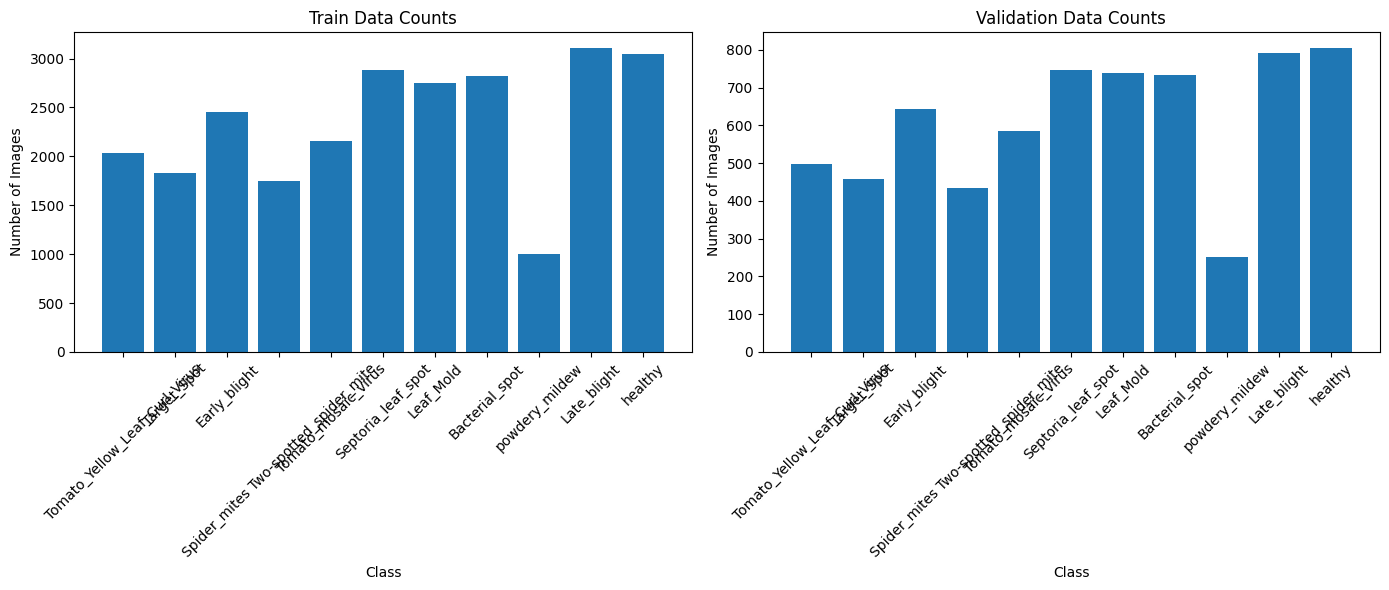

In [9]:
train_dir = path + "/train"
valid_dir = path + "/valid"

def get_class_counts(data_dir):
    counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):

            counts[class_name] = len(os.listdir(class_path))
    return counts


train_counts = get_class_counts(train_dir)
valid_counts = get_class_counts(valid_dir)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(train_counts.keys(), train_counts.values())
axs[0].set_title("Train Data Counts")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Number of Images")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(valid_counts.keys(), valid_counts.values())
axs[1].set_title("Validation Data Counts")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Number of Images")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. 모델 구성

In [10]:
batch_size = 40
epochs = 10
patience = 5
threshold = 0.99
factor = 0.5
freeze = False

img_size = (224, 224)
channels = 3
img_shape = (channels, img_size[0], img_size[1])

train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = path + "/train"
valid_dir = path + "/valid"
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)

num_classes = len(train_dataset.classes)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class EfficientNetB3Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.45):
        super(EfficientNetB3Custom, self).__init__()
        self.base_model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        num_features = self.base_model.num_features

        self.bn = nn.BatchNorm1d(num_features, momentum=0.99, eps=0.001)

        self.fc1 = nn.Linear(num_features, 256)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EfficientNetB3Custom(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=0.016)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=factor, threshold=threshold)

# 3-0. DB 커넥션

In [11]:
!pip install PyMySQL
!pip install sqlalchemy

In [ ]:
from sqlalchemy import create_engine
from datetime import datetime

db_adapter = "mysql+pymysql://"

db_url = db_adapter + "avnadmin:~~~~/training_history"

ssl_args = {
    "ssl_ca": "/content/ca.pem"
}

engine = create_engine(db_url, connect_args=ssl_args)

conn = engine.raw_connection()
cursor = conn.cursor()

# 3. Teacher 모델 학습 with EfficientNetB3

In [13]:
train_start_time = datetime.now()
insert_train_sql = "INSERT INTO efficient_net_B3_train (start_time) VALUES (%s)"
cursor.execute(insert_train_sql, (train_start_time,))
conn.commit()
train_id = cursor.lastrowid
print(f"train_id:{train_id}")

best_val_acc = 0

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    epoch_start_time = datetime.now()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_end_time = datetime.now()

    val_loss = val_loss / len(valid_dataset)
    val_acc = correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}\n")

    scheduler.step(val_loss)


    insert_epoch_sql = """
        INSERT INTO efficient_net_B3_epochs
        (train_id, epoch_id, epoch_start_time, epoch_end_time, train_loss, train_accuracy, val_loss, val_accuracy)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """
    cursor.execute(insert_epoch_sql, (
        train_id,
        epoch + 1,
        epoch_start_time,
        epoch_end_time,
        train_loss,
        train_acc,
        val_loss,
        val_acc
    ))
    conn.commit()

    # best case 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientNetB3_model.pth')
        print("==== best case ====")



    # threshold를 넘으면 학습 종료
    if val_acc >= threshold:
        print("==== Validation accuracy threshold reached, stopping training ====")
        break

# 학습 종료 시간 로깅
train_end_time = datetime.now()
update_train_sql = "UPDATE efficient_net_B3_train SET end_time = %s WHERE train_id = %s"
cursor.execute(update_train_sql, (train_end_time, train_id))
conn.commit()

train_id:4
Epoch 1/10, Train Loss: 0.4171, Train Acc: 0.8725
Epoch 1/10, Valid Loss: 0.3700, Valid Acc: 0.8860

==== best case ====
Epoch 2/10, Train Loss: 0.3428, Train Acc: 0.9075
Epoch 2/10, Valid Loss: 0.4092, Valid Acc: 0.8779

Epoch 3/10, Train Loss: 0.3666, Train Acc: 0.9056
Epoch 3/10, Valid Loss: 0.3551, Valid Acc: 0.8971

==== best case ====
Epoch 4/10, Train Loss: 0.3659, Train Acc: 0.9046
Epoch 4/10, Valid Loss: 0.3692, Valid Acc: 0.9074

==== best case ====
Epoch 5/10, Train Loss: 0.3638, Train Acc: 0.9071
Epoch 5/10, Valid Loss: 0.4620, Valid Acc: 0.8577

Epoch 6/10, Train Loss: 0.3709, Train Acc: 0.9041
Epoch 6/10, Valid Loss: 0.3359, Valid Acc: 0.9116

==== best case ====
Epoch 7/10, Train Loss: 0.3528, Train Acc: 0.9085
Epoch 7/10, Valid Loss: 0.4041, Valid Acc: 0.8830

Epoch 8/10, Train Loss: 0.2712, Train Acc: 0.9352
Epoch 8/10, Valid Loss: 0.2771, Valid Acc: 0.9300

==== best case ====
Epoch 9/10, Train Loss: 0.2504, Train Acc: 0.9416
Epoch 9/10, Valid Loss: 0.4138,

# 4. 시각화

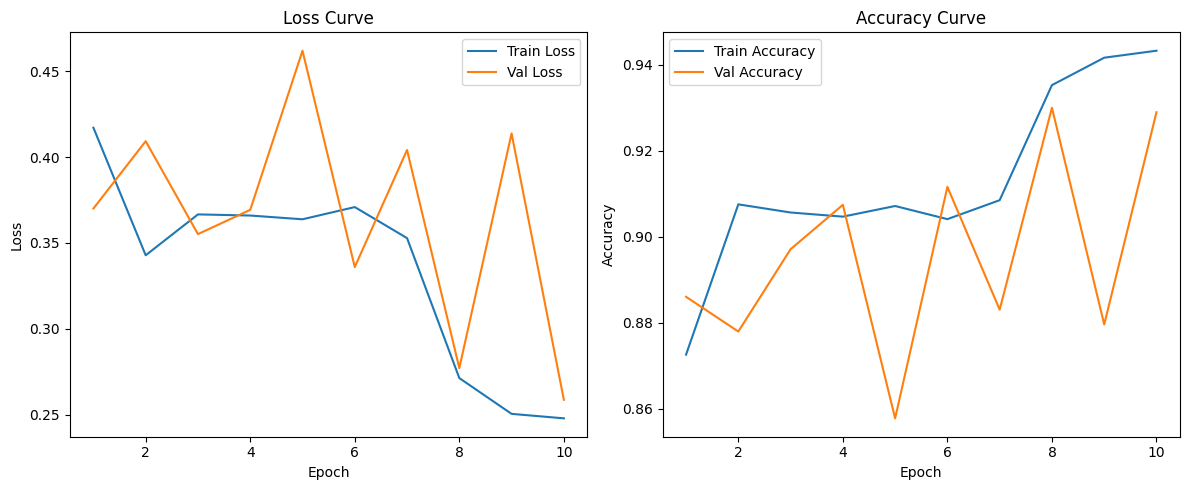

In [14]:
epochs_range = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label="Train Loss")
plt.plot(epochs_range, val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, val_acc_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

Classification Report:
                                       precision    recall  f1-score   support

                      Bacterial_spot       0.95      0.91      0.93       732
                        Early_blight       0.95      0.89      0.92       643
                         Late_blight       0.95      0.88      0.91       792
                           Leaf_Mold       0.98      0.94      0.96       739
                  Septoria_leaf_spot       0.79      0.94      0.86       746
Spider_mites Two-spotted_spider_mite       0.97      0.97      0.97       435
                         Target_Spot       0.97      0.92      0.94       457
       Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98       498
                 Tomato_mosaic_virus       0.93      0.97      0.95       584
                             healthy       0.92      0.98      0.95       806
                      powdery_mildew       0.92      0.81      0.86       252

                            accuracy  

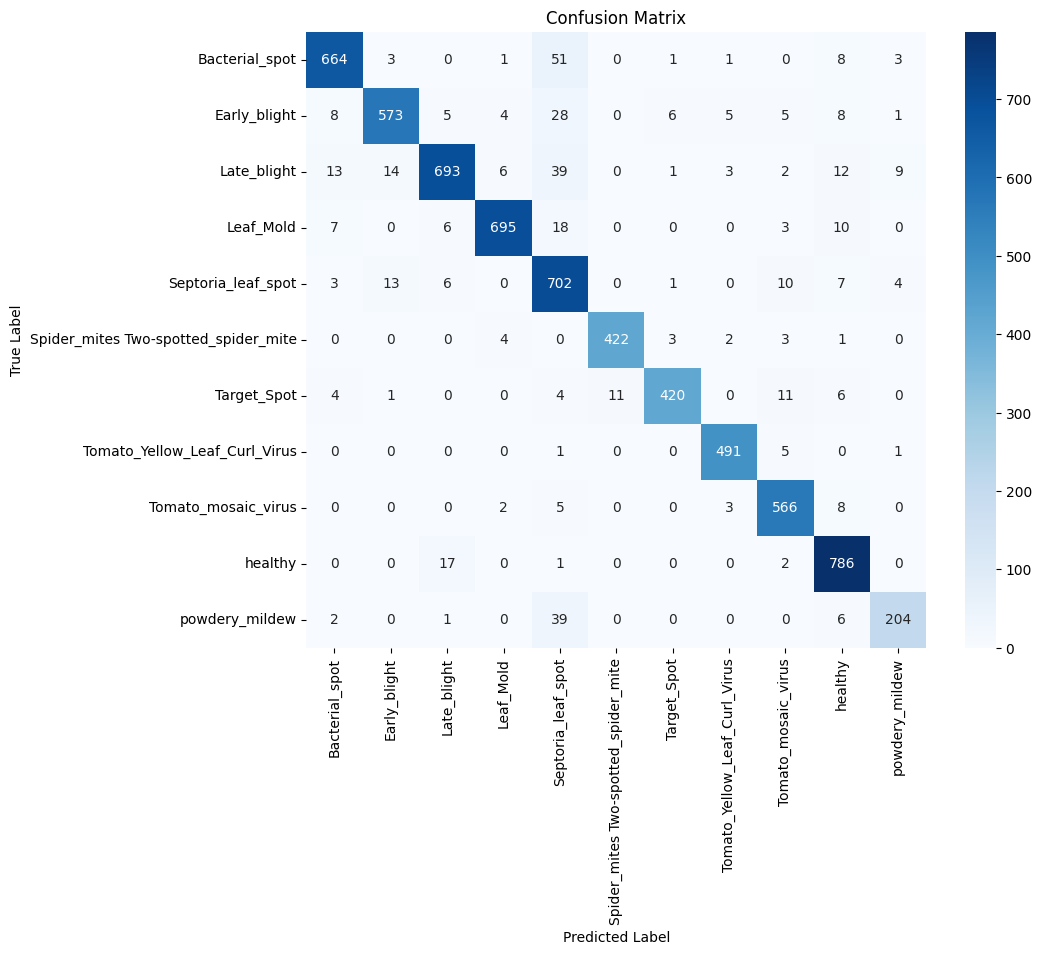

In [15]:
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:\n", cr)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# 클래스 이름 가져오기 (ImageFolder 기준)
class_names = train_dataset.classes

# best 모델 불러오기 (옵션)
model.load_state_dict(torch.load('best_efficientNetB3_model.pth'))

# valid 데이터셋에 대해 혼동행렬 출력
plot_confusion_matrix(model, valid_loader, class_names)

# 5. KD 함수 정의

In [16]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction="batchmean")

    def forward(self, student_outputs, teacher_outputs, labels):
        hard_loss = self.ce_loss(student_outputs, labels)

        T = self.temperature
        student_log_probs = F.log_softmax(student_outputs / T, dim=1)
        teacher_probs = F.softmax(teacher_outputs / T, dim=1)
        distill_loss = self.kl_loss(student_log_probs, teacher_probs) * (T * T)

        loss = self.alpha * distill_loss + (1.0 - self.alpha) * hard_loss
        return loss

# 6. 경량화 모델 경쟁시키기

## 6-1-1. resnet18 파인튜닝

In [17]:
class Resnet18Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.45):
        super(Resnet18Custom, self).__init__()

        self.base_model = timm.create_model("resnet18", pretrained=True, num_classes=0)

        num_features = self.base_model.num_features

        self.bn = nn.BatchNorm1d(num_features, momentum=0.99, eps=0.001)

        self.fc1 = nn.Linear(num_features, 256)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model(x)

        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 6-2-2. resnet18 하이퍼파라미터

In [18]:
alpha = 0.5
temperature = 4.0

student_model_resnet = Resnet18Custom(num_classes=num_classes, dropout_rate=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model_resnet = student_model_resnet.to(device)

optimizer = optim.Adamax(student_model_resnet.parameters(), lr=0.001, weight_decay=0.016)
distill_criterion = DistillationLoss(temperature=temperature, alpha=alpha)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=patience, factor=factor, threshold=threshold
)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

## 6-1-3. resnet18 학습

In [19]:
train_start_time = datetime.now()
insert_train_sql = "INSERT INTO res_net_18_train (start_time) VALUES (%s)"
cursor.execute(insert_train_sql, (train_start_time,))
conn.commit()
train_id = cursor.lastrowid
print(f"train_id:{train_id}")

best_val_acc = 0
resnet_total_val_time = 0

resnet_train_loss_list = []
resnet_train_acc_list = []
resnet_val_loss_list = []
resnet_val_acc_list = []

student_model_resnet.to(device)

for epoch in range(epochs):
    model.eval()
    student_model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    epoch_start_time = datetime.now()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass (student + teacher)
        student_outputs = student_model_resnet(inputs)
        with torch.no_grad():
            teacher_outputs = model(inputs)

        # Distillation Loss
        loss = distill_criterion(student_outputs, teacher_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(student_outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    resnet_train_loss_list.append(train_loss)
    resnet_train_acc_list.append(train_acc)

    student_model_resnet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    start_val_time = time.time()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_outputs = student_model_resnet(inputs)
            teacher_outputs = model(inputs)

            loss = distill_criterion(student_outputs, teacher_outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(student_outputs, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_end_time = datetime.now()

    val_loss = val_loss / len(valid_dataset)
    val_acc = correct_val / total_val
    resnet_val_loss_list.append(val_loss)
    resnet_val_acc_list.append(val_acc)

    val_time = time.time() - start_val_time
    resnet_total_val_time += val_time
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}\n")
    print(f"Epoch {epoch+1} validation time: {val_time:.2f} seconds\n")

    insert_epoch_sql = """
        INSERT INTO res_net_18_epochs
        (train_id, epoch_id, epoch_start_time, epoch_end_time, train_loss, train_accuracy, val_loss, val_accuracy)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """
    cursor.execute(insert_epoch_sql, (
        train_id,
        epoch + 1,
        epoch_start_time,
        epoch_end_time,
        train_loss,
        train_acc,
        val_loss,
        val_acc
    ))
    conn.commit()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(student_model_resnet.state_dict(), 'best_resnet18_model.pth')
        print("==== best case ====")

    if val_acc >= threshold:
        print("==== Validation accuracy threshold reached ====")
        break


# 학습 종료 시간 로깅
train_end_time = datetime.now()
update_train_sql = "UPDATE res_net_18_train SET end_time = %s WHERE train_id = %s"
cursor.execute(update_train_sql, (train_end_time, train_id))
conn.commit()

train_id:3
Epoch 1/10, Train Loss: 0.7258, Train Acc: 0.7962
Epoch 1/10, Valid Loss: 0.4473, Valid Acc: 0.8659

Epoch 1 validation time: 14.20 seconds

==== best case ====
Epoch 2/10, Train Loss: 0.4397, Train Acc: 0.8723
Epoch 2/10, Valid Loss: 0.3899, Valid Acc: 0.8851

Epoch 2 validation time: 14.29 seconds

==== best case ====
Epoch 3/10, Train Loss: 0.4319, Train Acc: 0.8751
Epoch 3/10, Valid Loss: 0.4791, Valid Acc: 0.8525

Epoch 3 validation time: 14.23 seconds

Epoch 4/10, Train Loss: 0.4182, Train Acc: 0.8805
Epoch 4/10, Valid Loss: 0.3845, Valid Acc: 0.8887

Epoch 4 validation time: 14.25 seconds

==== best case ====
Epoch 5/10, Train Loss: 0.3962, Train Acc: 0.8891
Epoch 5/10, Valid Loss: 0.5277, Valid Acc: 0.8636

Epoch 5 validation time: 14.27 seconds

Epoch 6/10, Train Loss: 0.3707, Train Acc: 0.8972
Epoch 6/10, Valid Loss: 0.3910, Valid Acc: 0.8746

Epoch 6 validation time: 14.18 seconds

Epoch 7/10, Train Loss: 0.3622, Train Acc: 0.8992
Epoch 7/10, Valid Loss: 0.3170, V

## 6-2-1. EfficientNetB0 파인튜닝

In [20]:
class EfficientnetB0Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.45):
        super(EfficientnetB0Custom, self).__init__()

        # EfficientNetB0 베이스 모델 로드 (마지막 FC layer 제외)
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)

        # 베이스 모델의 마지막 출력 피처 개수
        num_features = self.base_model.num_features

        # Batch Normalization
        self.bn = nn.BatchNorm1d(num_features, momentum=0.99, eps=0.001)

        # 분류를 위한 Fully Connected Layers
        self.fc1 = nn.Linear(num_features, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model(x)  # EfficientNetB0로 피처 추출
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 6-2-2. EfficientNetB0 하이퍼파라미터

In [21]:
alpha = 0.5
temperature = 4.0

student_model_efficientnetB0 = EfficientnetB0Custom(num_classes=num_classes, dropout_rate=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model_efficientnetB0 = student_model_efficientnetB0.to(device)

optimizer = optim.Adamax(student_model_efficientnetB0.parameters(), lr=0.001, weight_decay=0.016)
distill_criterion = DistillationLoss(temperature=temperature, alpha=alpha)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=patience, factor=factor, threshold=threshold
)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

## 6-2-3. EfficientNetB0 학습

In [22]:
train_start_time = datetime.now()
insert_train_sql = "INSERT INTO efficient_net_B0_train (start_time) VALUES (%s)"
cursor.execute(insert_train_sql, (train_start_time,))
conn.commit()
train_id = cursor.lastrowid
print(f"train_id:{train_id}")

best_val_acc = 0
efficientnetB0_total_val_time = 0

efficientnetB0_train_loss_list = []
efficientnetB0_train_acc_list = []
efficientnetB0_val_loss_list = []
efficientnetB0_val_acc_list = []

student_model_efficientnetB0.to(device)

for epoch in range(epochs):
    model.eval()
    student_model_efficientnetB0.train()
    running_loss = 0.0
    correct = 0
    total = 0

    epoch_start_time = datetime.now()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass (student + teacher)
        student_outputs = student_model_efficientnetB0(inputs)
        with torch.no_grad():
            teacher_outputs = model(inputs)

        # Distillation Loss
        loss = distill_criterion(student_outputs, teacher_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(student_outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total
    efficientnetB0_train_loss_list.append(train_loss)
    efficientnetB0_train_acc_list.append(train_acc)

    student_model_efficientnetB0.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    start_val_time = time.time()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_outputs = student_model_efficientnetB0(inputs)
            teacher_outputs = model(inputs)

            loss = distill_criterion(student_outputs, teacher_outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(student_outputs, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_end_time = datetime.now()

    val_loss = val_loss / len(valid_dataset)
    val_acc = correct_val / total_val
    efficientnetB0_val_loss_list.append(val_loss)
    efficientnetB0_val_acc_list.append(val_acc)

    val_time = time.time() - start_val_time
    efficientnetB0_total_val_time += val_time
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}")
    print(f"Epoch {epoch+1} validation time: {val_time:.2f} seconds\n")

    insert_epoch_sql = """
        INSERT INTO efficient_net_B0_epochs
        (train_id, epoch_id, epoch_start_time, epoch_end_time, train_loss, train_accuracy, val_loss, val_accuracy)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """
    cursor.execute(insert_epoch_sql, (
        train_id,
        epoch + 1,
        epoch_start_time,
        epoch_end_time,
        train_loss,
        train_acc,
        val_loss,
        val_acc
    ))
    conn.commit()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(student_model_efficientnetB0.state_dict(), 'best_efficientnetB018_model.pth')
        print("==== best case ====\n\n")

    if val_acc >= threshold:
        print("==== Validation accuracy threshold reached ====")
        break


# 학습 종료 시간 로깅
train_end_time = datetime.now()
update_train_sql = "UPDATE efficient_net_B0_train SET end_time = %s WHERE train_id = %s"
cursor.execute(update_train_sql, (train_end_time, train_id))
conn.commit()

train_id:3
Epoch 1/10, Train Loss: 0.4362, Train Acc: 0.8823
Epoch 1/10, Valid Loss: 0.4266, Valid Acc: 0.8691
Epoch 1 validation time: 14.25 seconds

==== best case ====


Epoch 2/10, Train Loss: 0.3700, Train Acc: 0.8990
Epoch 2/10, Valid Loss: 0.4934, Valid Acc: 0.8604
Epoch 2 validation time: 14.18 seconds

Epoch 3/10, Train Loss: 0.3769, Train Acc: 0.8972
Epoch 3/10, Valid Loss: 0.3708, Valid Acc: 0.8986
Epoch 3 validation time: 14.21 seconds

==== best case ====


Epoch 4/10, Train Loss: 0.3914, Train Acc: 0.8937
Epoch 4/10, Valid Loss: 0.4076, Valid Acc: 0.8805
Epoch 4 validation time: 14.28 seconds

Epoch 5/10, Train Loss: 0.3993, Train Acc: 0.8945
Epoch 5/10, Valid Loss: 0.4232, Valid Acc: 0.8912
Epoch 5 validation time: 14.42 seconds

Epoch 6/10, Train Loss: 0.4026, Train Acc: 0.8937
Epoch 6/10, Valid Loss: 0.3320, Valid Acc: 0.9110
Epoch 6 validation time: 14.24 seconds

==== best case ====


Epoch 7/10, Train Loss: 0.3898, Train Acc: 0.8956
Epoch 7/10, Valid Loss: 0.3430, V

# 7. 경량화 모델 결과 시각화

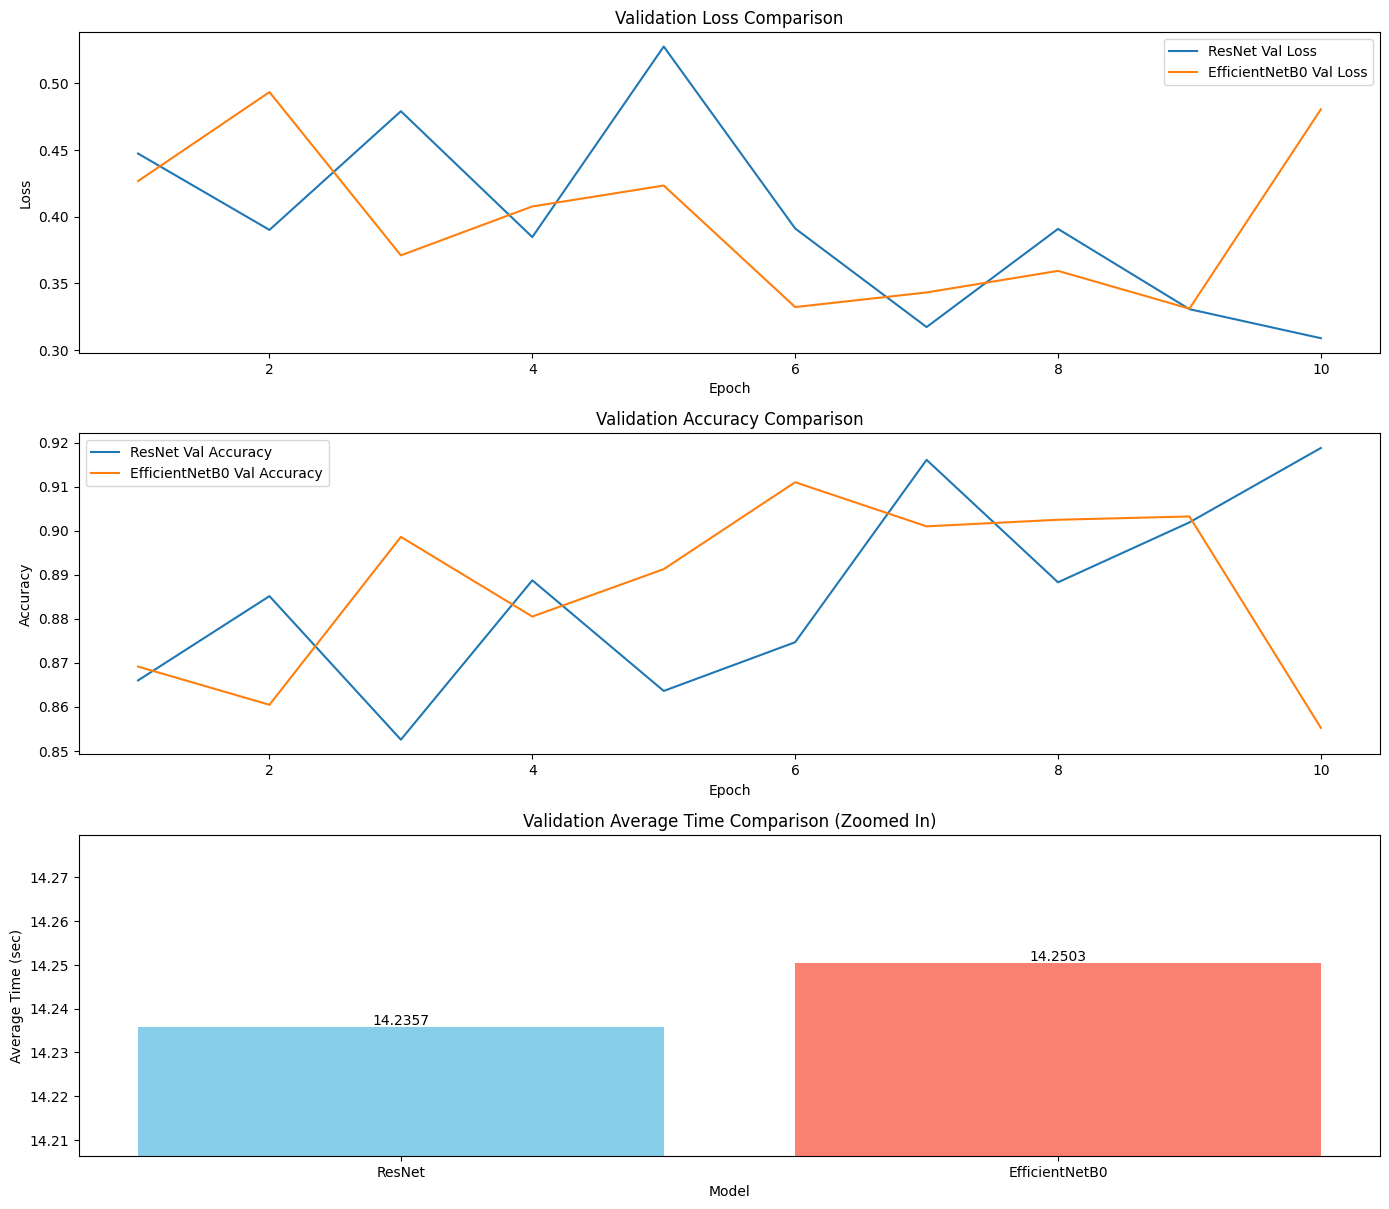

In [23]:
epochs_range = range(1, len(resnet_train_loss_list) + 1)

plt.figure(figsize=(14, 20))

# 3. Validation Loss
plt.subplot(5, 1, 3)
plt.plot(epochs_range, resnet_val_loss_list, label="ResNet Val Loss")
plt.plot(epochs_range, efficientnetB0_val_loss_list, label="EfficientNetB0 Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison")
plt.legend()

# 4. Validation Accuracy
plt.subplot(5, 1, 4)
plt.plot(epochs_range, resnet_val_acc_list, label="ResNet Val Accuracy")
plt.plot(epochs_range, efficientnetB0_val_acc_list, label="EfficientNetB0 Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()

# 5. Validation Average Time (막대그래프로 비교)
plt.subplot(5, 1, 5)
# 전체 에폭 동안의 총 validation 시간을 epochs로 나눠서 평균값 계산
resnet_avg_time = resnet_total_val_time / float(epochs)
efficientnetB0_avg_time = efficientnetB0_total_val_time / float(epochs)
models = ['ResNet', 'EfficientNetB0']
avg_times = [resnet_avg_time, efficientnetB0_avg_time]

# 서로 다른 색상 지정
colors = ['skyblue', 'salmon']
bars = plt.bar(models, avg_times, color=colors)

# 작은 차이가 크게 보이도록 y축 범위를 확대
min_time = min(avg_times)
max_time = max(avg_times)
diff = max_time - min_time
if diff == 0:
    diff = 0.01  # 동일한 값일 경우 대비
margin = diff * 2  # 차이의 두 배만큼 margin을 부여
plt.ylim(min_time - margin, max_time + margin)

plt.xlabel("Model")
plt.ylabel("Average Time (sec)")
plt.title("Validation Average Time Comparison (Zoomed In)")

# 각 막대 위에 평균 시간 텍스트 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()